# ASSIGNMENT 3 - BDE
### STREAMING WITH KAFKA AND SPARK STREAMING
#### TEAM - FINAL FANTASY III

In [1]:
# Importing required packages and libraries
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import confluent_kafka
import random as rd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
#Instantiate a local spark session and saved variable
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
#Subscribe to the topic stock-trades from the Kafka broker and read latest data into a Spark dataframe called stream_df
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "latest") \
  .option("subscribe", "stock-trades") \
  .load()

In [4]:

stream_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
raw_stream = stream_df \
    .writeStream \
    .format("memory") \
    .queryName("raw_stocktrade_view") \
    .start()

In [6]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM raw_stocktrade_view').show(20))
time.sleep(10)

+---+-----+-----+---------+------+---------+-------------+
|key|value|topic|partition|offset|timestamp|timestampType|
+---+-----+-----+---------+------+---------+-------------+
+---+-----+-----+---------+------+---------+-------------+



None

In [7]:
raw_stream.stop()

In [8]:
#Create string stream from Stock Trade data
string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
    .withColumn("value", stream_df["value"].cast(StringType()))

In [9]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_stocktrade_view") \
    .start()

In [10]:
#Show 5 second output
clear_output(wait=True)
display(spark.sql('SELECT * FROM string_stocktrade_view').show(20, False))
time.sleep(5)

+---+-----+-----+---------+------+---------+-------------+
|key|value|topic|partition|offset|timestamp|timestampType|
+---+-----+-----+---------+------+---------+-------------+
+---+-----+-----+---------+------+---------+-------------+



None

In [11]:
string_stream.stop()

In [12]:
#Define values in the JSON from streaming
schema_stocktrade = StructType([
    StructField('payload', StructType([
        StructField("side", StringType(),  True),
        StructField("quantity", IntegerType(), True),
        StructField("symbol", StringType(),  True),
        StructField("price", IntegerType(),  True),
        StructField("account", StringType(),  True),
        StructField("userid", StringType(),  True)      
    ]))
])

### PART 3a - STREAM CREATION

In [13]:
#Stream 1 - JSON value stream
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrade))

In [14]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- payload: struct (nullable = true)
 |    |    |-- side: string (nullable = true)
 |    |    |-- quantity: integer (nullable = true)
 |    |    |-- symbol: string (nullable = true)
 |    |    |-- price: integer (nullable = true)
 |    |    |-- account: string (nullable = true)
 |    |    |-- userid: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [15]:
#Stream 2 - Define Stock Trade values stream
stocktrade_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.payload.account", \
        "value.payload.symbol", \
        "value.payload.side", \
        "value.payload.price", \
        "value.payload.quantity", \
        "value.payload.userid"
    )

In [16]:
stocktrade_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- account: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- side: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- userid: string (nullable = true)



In [17]:
#Create base Stock Trade View stream
stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()

In [18]:
clear_output(wait=True)

display(spark.sql('SELECT * FROM stocktrade_view').show(20))
time.sleep(1)

+---------+-----------+---------------+-------+------+----+-----+--------+------+
|event_key|event_topic|event_timestamp|account|symbol|side|price|quantity|userid|
+---------+-----------+---------------+-------+------+----+-----+--------+------+
+---------+-----------+---------------+-------+------+----+-----+--------+------+



None

In [19]:
#Create 
clear_output(wait=True)
display(spark.sql('SELECT event_key, COUNT(1) AS count, round(mean(price),0) as price, round(mean(quantity),0) as qty FROM stocktrade_view GROUP BY 1').show(20))
time.sleep(1)

+---------+-----+-----+------+
|event_key|count|price|   qty|
+---------+-----+-----+------+
|    ZXZZT|    5|283.0|2220.0|
|    ZVZZT|    3|102.0|2526.0|
|    ZTEST|    3|395.0|1801.0|
|    ZWZZT|    3|249.0|2566.0|
|    ZJZZT|    1|651.0|4592.0|
|      ZVV|    4|517.0|2191.0|
|     ZBZX|    3|467.0|3045.0|
+---------+-----+-----+------+



None

In [20]:
stocktrade_stream.stop()

### Part 3b - WINDOW STEAM WITH WATERMARK

In [21]:
#Set Window parameters
window_duration = '60 seconds'
slide_duration = '10 seconds'

In [22]:
#Create window view from stock_trade stream
windowed_count_df = stocktrade_stream_df \
    .withWatermark("event_timestamp", "1 minutes") \
    .groupBy(F.window(stocktrade_stream_df.event_timestamp, window_duration, slide_duration), stocktrade_stream_df.symbol) \
    .count()

### Part 3c - SPARK QUERY

In [23]:
#Count view = count of trade symbols within a 
count_stream = windowed_count_df \
    .writeStream \
    .format("memory") \
    .outputMode("Complete") \
    .queryName("count_view") \
    .start()

In [27]:
while True:
    clear_output(wait=True)
    display(spark.sql('SELECT * FROM count_view LIMIT 20').show())
    time.sleep(1)

KeyboardInterrupt: 

In [28]:
count_stream.stop()

### PART 3e - VISUALISATIONS

In [29]:
# Graphing real-time data
# loading packages
import time
import random as rd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

# sample data from stocktrade_view
x_y = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 2000''')
x_y_df = x_y.toPandas()
x_y_df

,event_key,event_topic,event_timestamp,account,symbol,side,price,quantity,userid
0,ZXZZT,stock-trades,2021-06-13 06:38:24.769,XYZ789,ZXZZT,BUY,387,1375,User_6
1,ZBZX,stock-trades,2021-06-13 06:38:24.673,XYZ789,ZBZX,BUY,828,161,User_7
2,ZWZZT,stock-trades,2021-06-13 06:38:24.661,ABC123,ZWZZT,SELL,30,4748,User_5
3,ZTEST,stock-trades,2021-06-13 06:38:24.569,ABC123,ZTEST,BUY,465,1040,User_5
4,ZWZZT,stock-trades,2021-06-13 06:38:24.569,XYZ789,ZWZZT,BUY,347,706,User_5
...,...,...,...,...,...,...,...,...,...
72,ZWZZT,stock-trades,2021-06-13 06:38:21.220,XYZ789,ZWZZT,SELL,408,2986,User_9
73,ZJZZT,stock-trades,2021-06-13 06:38:21.125,XYZ789,ZJZZT,SELL,651,4592,User_8
74,ZTEST,stock-trades,2021-06-13 06:38:21.054,LMN456,ZTEST,SELL,400,860,User_9
75,ZBZX,stock-trades,2021-06-13 06:38:21.044,ABC123,ZBZX,SELL,652,4755,User_5


In [30]:
# The following routine displays 3 graphs which include 1 scatter plot, 1 line graph and 1 column chart) 
def bunchofplots(x1, y1, title1, x2, data2, labels2, title2, x3, y3, title3):
    clear_output(wait=True)
    # Placing the plots in the plane
    fig = plt.figure(figsize = (15,10))
    plot1 = plt.subplot2grid((4, 9), (0, 0), rowspan=2, colspan=3)
    plot2 = plt.subplot2grid((4, 9), (0, 4), rowspan=4, colspan=5)
    plot3 = plt.subplot2grid((4, 9), (2, 0), rowspan=2, colspan=3)
  
    # Using numpy to create an array x
    x = [x for x in range(0,11)]

    
    # scatter plot
    plot1.scatter(x1, y1, color='k') # black dots
    m, b = np.polyfit(x1, y1, 1)
    plot1.plot(x1, [x * m for x in x1] + b) # showing the line of best-fit
    plot1.set(xlabel = 'Price', ylabel = 'Quantity')
    plot1.set_title(title1)

    
    # column chart
    plot2.bar(x2 + 0.00, data2[0], color = 'g', width = 0.25)
    plot2.bar(x2 + 0.25, data2[1], color = 'r', width = 0.25)
    plot2.legend(labels=['BUY', 'SELL'])
    plot2.set_xticks(x2)
    plot2.set_xticklabels(labels2)

    plot2.set_title(title2)
    plot2.grid(True)
    plot2.set(xlabel = 'Stock symbol', ylabel = 'Traded amount in $')

    
    # line graph
    plot3.plot(x3, y3, color='r') 
    plot3.set_title(title3)
    plot3.set(xlabel = 'Time', ylabel = 'Price')

    # Packing all the plots and displaying them
    plt.tight_layout()
    plt.show()

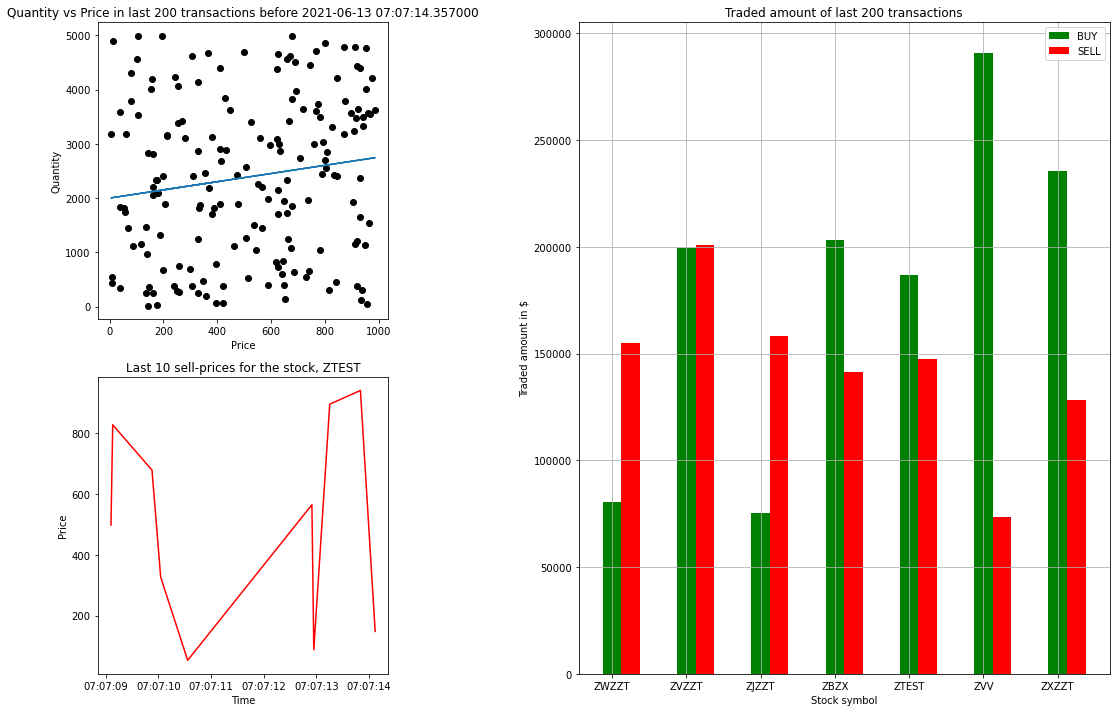

KeyboardInterrupt: 

In [31]:
# combining and updating 3 graphs simultaneously 
stocktrade_stream.stop()

stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()    


while True:
    # aggregating streamed data and displaying in a scatter plot
    # plotting Quantity vs Price
    x_y1 = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 200''')
    x_y1_df = x_y1.toPandas()
    
    if x_y1_df.shape[0] > 0: 
        x1 = x_y1_df.price
        y1 = x_y1_df.quantity
        title1 = f'Quantity vs Price in last 200 transactions before {max(x_y1_df.event_timestamp)}'

    
    # aggregating the streamed data and displaying in a column plot
    # plotting traded amount vs stock (symbol)
    x_y2= spark.sql('''SELECT 
                        symbol
                        , side
                        , sum(price*quantity)/100 as traded_amount_in_dollars
                        , max(event_timestamp) as max_event_timestamp
                    FROM (select * from stocktrade_view order by event_timestamp desc limit 200) as current
                    group by 
                            side
                            , symbol

                   ''')
    x_y2_df = x_y2.toPandas()
    
    labels2 = list(x_y2_df.symbol.unique())

    data2 = [ x_y2_df[x_y2_df['side'] == 'BUY']['traded_amount_in_dollars']
            ,x_y2_df[x_y2_df['side'] == 'SELL']['traded_amount_in_dollars']
           ]
    
    x2 = np.arange(len(x_y2_df.symbol.unique()))
 
    title2 = 'Traded amount of last 200 transactions'
    
    
    # aggregating the streamed data and displaying in a line plot
    x_y3= spark.sql('''SELECT 
                            price
                            , event_timestamp
                            FROM stocktrade_view 
                            where side = 'SELL'
                            and symbol = 'ZTEST'
                            order by event_timestamp desc limit 10
                    ''')
    
    x_y3_df = x_y3.toPandas()
    
    x3 = x_y3_df.event_timestamp
    y3 = x_y3_df.price
    
    title3 = 'Last 10 sell-prices for the stock, ZTEST'
    
    
    print('Preparing streamed data for plots - refreshing every 10 s')
    if (x_y1_df.shape[0] > 0):
        
        bunchofplots(x1, y1, title1, x2, data2, labels2, title2, x3, y3, title3)
    
    
    # updating every 10 s
    time.sleep(10)   

### PART 3d - PARQUET SINK 

In [32]:
# Create dataframe for training and test data, then export to parquet file
from pyspark import SparkFiles
from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [33]:
# Capture training data - Automatically stops when rows exceed 10000 (checking every 30 seconds). 
df = sqlContext.sql('SELECT * FROM stocktrade_view')

while(df.count() < 10000):
    time.sleep(30)
    df = sqlContext.sql('SELECT * FROM stocktrade_view')

df.count()

10566

In [34]:
# Set whole streaming dataset to 10000 rows
df_train = sqlContext.sql('SELECT * FROM stocktrade_view order by event_timestamp limit 8000')
df_test = sqlContext.sql('SELECT * FROM stocktrade_view order by event_timestamp desc limit 2000')
df_concat = df_train.union(df_test)
df_concat.count()

10000

In [35]:
# Sink all data and traning data to parquet files separately
df_train.write.parquet('./query2_trainingdata.parquet',mode='append')
df_concat.write.parquet('./query2_alldata.parquet',mode='append')

In [36]:
# Read parquet file for visualisation and machine learning
query2_df = sqlContext.read.parquet('./query2_alldata.parquet')
query2_df.show(20)

+---------+------------+--------------------+-------+------+----+-----+--------+------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|
+---------+------------+--------------------+-------+------+----+-----+--------+------+
|    ZVZZT|stock-trades|2021-06-13 07:07:...| XYZ789| ZVZZT|SELL|  411|    1897|User_7|
|    ZVZZT|stock-trades|2021-06-13 07:07:...| LMN456| ZVZZT| BUY|  253|    3377|User_4|
|    ZJZZT|stock-trades|2021-06-13 07:07:...| ABC123| ZJZZT| BUY|  925|    3648|User_7|
|    ZXZZT|stock-trades|2021-06-13 07:07:...| XYZ789| ZXZZT|SELL|  543|    1046|User_1|
|      ZVV|stock-trades|2021-06-13 07:07:...| ABC123|   ZVV| BUY|   62|    3178|User_8|
|    ZTEST|stock-trades|2021-06-13 07:07:...| LMN456| ZTEST|SELL|  270|    3418|User_9|
|    ZTEST|stock-trades|2021-06-13 07:07:...| ABC123| ZTEST| BUY|  329|    4134|User_8|
|    ZVZZT|stock-trades|2021-06-13 07:07:...| XYZ789| ZVZZT| BUY|  668|    3429|User_6|
|    ZTEST|stock-trades|2021-06-

### PART 4a - ML WITH SPARK

In [37]:
# Setup pipelines to train regression model to predict "quantity"
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer,VectorAssembler,VectorIndexer
from pyspark.ml.feature import OneHotEncoder

In [38]:
cat_cols = ['userid','account','symbol','side']

In [39]:
stages = []

In [40]:
for cat_col in cat_cols:
    col_indexer = StringIndexer(inputCol=cat_col, outputCol =f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"],outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer, col_encoder]

In [41]:
num_cols = ['price']

In [42]:
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in cat_cols]

In [43]:
assembler = VectorAssembler(inputCols=cat_cols_ohe+num_cols, outputCol="features")

In [44]:
regression = LinearRegression(labelCol='quantity',regParam = 0, maxIter = 10)

In [45]:
stages += [assembler,regression]

In [46]:
print(stages)

[StringIndexer_0545b0ad3784, OneHotEncoder_6aa80ae58d2b, StringIndexer_e41dc164d5fc, OneHotEncoder_ef2ab78ff4e8, StringIndexer_b5537e86502e, OneHotEncoder_34ed8798af42, StringIndexer_d3ed88643036, OneHotEncoder_5daf2714152a, VectorAssembler_fa0228ba1552, LinearRegression_ba152b6feab6]


In [47]:
pipeline = Pipeline(stages=stages)

In [48]:
pipeline = pipeline.fit(query2_df)

In [49]:
train_assessment = pipeline.transform(query2_df)

In [50]:
#Trained regression model evaluation- RMSE
lr_evaluator = RegressionEvaluator(metricName="rmse", labelCol=regression.getLabelCol(), \
                                   predictionCol=regression.getPredictionCol())
RMSE = lr_evaluator.evaluate(train_assessment)
print(RMSE)

1441.2931935753345


In [51]:
train_assessment.show(10)

+---------+------------+--------------------+-------+------+----+-----+--------+------+----------+-------------+-----------+-------------+----------+-------------+--------+-------------+--------------------+------------------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|userid_ind|   userid_ohe|account_ind|  account_ohe|symbol_ind|   symbol_ohe|side_ind|     side_ohe|            features|        prediction|
+---------+------------+--------------------+-------+------+----+-----+--------+------+----------+-------------+-----------+-------------+----------+-------------+--------+-------------+--------------------+------------------+
|    ZVZZT|stock-trades|2021-06-13 07:07:...| XYZ789| ZVZZT|SELL|  411|    1897|User_7|       8.0|    (8,[],[])|        1.0|(2,[1],[1.0])|       1.0|(6,[1],[1.0])|     0.0|(1,[0],[1.0])|(18,[9,11,16,17],...|2530.2531950811617|
|    ZVZZT|stock-trades|2021-06-13 07:07:...| LMN456| ZVZZT| BUY|  253|    3377|User_4|     

In [52]:
train_assessment.count()

34667

In [53]:
test_assessment = pipeline.transform(df_test)

In [54]:
#Regression model test evaluation- RMSE
lr_evaluator = RegressionEvaluator(metricName="rmse", labelCol=regression.getLabelCol(), \
                                   predictionCol=regression.getPredictionCol())
RMSE = lr_evaluator.evaluate(test_assessment)
print(RMSE)

1449.017953887715


In [56]:
# Create pipelines for RF classification model to predict "side"
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [57]:
cols_list = ['side','userid','account','symbol','quantity','price']

In [58]:
cat_cols = ['userid','account','symbol']

In [59]:
stages = []
for cat_col in cat_cols:
    col_indexer = StringIndexer(inputCol=cat_col, outputCol =f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"],outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer, col_encoder]

In [60]:
target_indexer = StringIndexer(inputCol='side', outputCol='label')

In [61]:
num_cols = ['quantity','price']

In [62]:
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in cat_cols]

In [63]:
assembler = VectorAssembler(inputCols= cat_cols_ohe + num_cols, outputCol="features")

In [64]:
stages += [target_indexer,assembler]

In [65]:
print(stages)

[StringIndexer_f46415de4c1a, OneHotEncoder_21fc385f4074, StringIndexer_e873a435a989, OneHotEncoder_ea819fd7a684, StringIndexer_94fd74bd372d, OneHotEncoder_e17dd676d398, StringIndexer_4f6ea5cb7160, VectorAssembler_7f746b72bbd5]


In [66]:
pipeline = Pipeline(stages=stages)

In [67]:
pipeline_model = pipeline.fit(query2_df)

In [68]:
df = pipeline_model.transform(query2_df)

In [69]:
df = df.select(['label','features'] + cols_list)
df.show()

+-----+--------------------+----+------+-------+------+--------+-----+
|label|            features|side|userid|account|symbol|quantity|price|
+-----+--------------------+----+------+-------+------+--------+-----+
|  0.0|(18,[9,11,16,17],...|SELL|User_7| XYZ789| ZVZZT|    1897|  411|
|  1.0|(18,[2,8,11,16,17...| BUY|User_4| LMN456| ZVZZT|    3377|  253|
|  1.0|(18,[12,16,17],[1...| BUY|User_7| ABC123| ZJZZT|    3648|  925|
|  0.0|(18,[7,9,15,16,17...|SELL|User_1| XYZ789| ZXZZT|    1046|  543|
|  1.0|(18,[0,13,16,17],...| BUY|User_8| ABC123|   ZVV|    3178|   62|
|  0.0|(18,[1,8,10,16,17...|SELL|User_9| LMN456| ZTEST|    3418|  270|
|  1.0|(18,[0,10,16,17],...| BUY|User_8| ABC123| ZTEST|    4134|  329|
|  1.0|(18,[3,9,11,16,17...| BUY|User_6| XYZ789| ZVZZT|    3429|  668|
|  1.0|(18,[5,8,10,16,17...| BUY|User_5| LMN456| ZTEST|    4448|  745|
|  1.0|(18,[2,15,16,17],...| BUY|User_4| ABC123| ZXZZT|    2733|  706|
|  0.0|(18,[2,8,16,17],[...|SELL|User_4| LMN456|  ZBZX|     387|  308|
|  0.0

In [70]:
train_data,test_data = df.randomSplit([0.8,0.2], seed = 1)

In [71]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

In [72]:
rf_model = rf.fit(train_data)

In [73]:
train_preds = rf_model.transform(train_data)

In [74]:
test_preds = rf_model.transform(test_data)

In [75]:
#Create test prediction - output
train_preds.select(cols_list + ['prediction','probability']).show(10)

+----+------+-------+------+--------+-----+----------+--------------------+
|side|userid|account|symbol|quantity|price|prediction|         probability|
+----+------+-------+------+--------+-----+----------+--------------------+
|SELL|User_8| LMN456| ZTEST|     137|  393|       1.0|[0.47875469743298...|
|SELL|User_8| LMN456| ZTEST|     470|  933|       1.0|[0.49599375605152...|
|SELL|User_8| LMN456| ZTEST|     498|  363|       1.0|[0.47875469743298...|
|SELL|User_8| LMN456| ZTEST|     521|  243|       1.0|[0.47625139107393...|
|SELL|User_8| LMN456| ZTEST|     696|  661|       1.0|[0.48365536690112...|
|SELL|User_8| LMN456| ZTEST|    1081|  289|       1.0|[0.47385633573854...|
|SELL|User_8| LMN456| ZTEST|    1547|  417|       1.0|[0.48824779170913...|
|SELL|User_8| LMN456| ZTEST|    1767|  482|       1.0|[0.49220640337526...|
|SELL|User_8| LMN456| ZTEST|    2710|  880|       1.0|[0.49461924123541...|
|SELL|User_8| LMN456| ZTEST|    2870|  720|       1.0|[0.49607927372345...|
+----+------

In [76]:
#RF classification - AUROC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(metricName= 'areaUnderROC')
print(f"[AUROC] train:{evaluator.evaluate(train_preds)} - test: {evaluator.evaluate(test_preds)}")

[AUROC] train:0.5661856705770992 - test: 0.5201047231999099


In [77]:
#RF classification - Accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_multi = MulticlassClassificationEvaluator()
acc_metric = {evaluator_multi.metricName: "accuracy"}
print(f"[Accuracy] train:{evaluator_multi.evaluate(train_preds,acc_metric)} - test: {evaluator_multi.evaluate(test_preds, acc_metric)}")

[Accuracy] train:0.5455493991508958 - test: 0.5157864105921722


In [ ]:
spark.stop()